In [1]:
from mynotebooks import *
%matplotlib inline

arm = Box2DWorld.Arm(position=(0,0), nparts=3, bHand = False, bShrink = True, bLateralize = 1)  # Arm creation

Created Left Lateralized Arm Lims:  [-1.26, -2.73, -2.73] [1.26, 0.0, 0.0]


### Sensorimotor mapping :  $f(M, \Delta M) = \langle S, \Delta S \rangle$ with context

In [2]:
m_mins, m_maxs = arm.m_mins()+arm.dm_mins(), arm.m_maxs()+arm.dm_maxs()
s_mins, s_maxs = arm.s_mins()+arm.ds_mins(), arm.s_maxs()+arm.ds_maxs() 

env = SensoriMotor.RobotArmEnv(m_mins, m_maxs, s_mins, s_maxs)
fmdmsds = SensorimotorModel.from_configuration(env.conf, 'nearest_neighbor')
fmdmsds_im = DiscretizedProgress(env.conf, env.conf.s_dims, **{'x_card': 1000,'win_size': 20,'measure': competence_dist})

#### Learning with Motor Babbling and error filtering

In [3]:
def forward_error(probes = 10):
    fmdmsds.mode = "exploit"
    errors_s,errors_ds = [],[]
    for mdm in env.random_motors(n=probes):
        m,dm = mdm[:3], mdm[3:]    
        s = np.array(arm.gotoTargetJoints(m))
        s_after = np.array(arm.deltaMotorUpdate(dm))
        ds = s_after-s
        sds = np.hstack((s, ds))
        sds_pred = fmdmsds.forward_prediction(mdm)
        s_pred,ds_pred = sds_pred[:2],sds_pred[2:]
        errors_s.append( VectorFigUtils.dist(s,s_pred) )
        errors_ds.append( VectorFigUtils.dist(ds,ds_pred) )
    fmdmsds.mode = "explore"
    return errors_s, errors_ds
        
fmdmsds.mode = "explore"

errors = []
mean_error_s,mean_var_s = [],[]
mean_error_ds,mean_var_ds = [],[]

for i,mdm in enumerate(env.random_motors(n=500)):
    Box2DWorld.printProgress(i) 
    m,dm = mdm[:3], mdm[3:]    
    s = np.array(arm.gotoTargetJoints(m))
    s_after = np.array(arm.deltaMotorUpdate(dm))
    ds = s_after-s
    sds = np.hstack((s, ds))
    err = 10
    if(fmdmsds.size() > 0.5): 
        errors_s, errors_ds = forward_error(100)
        VectorFigUtils.error_monitor(errors_s,mean_error_s,mean_var_s)           
        VectorFigUtils.error_monitor(errors_ds,mean_error_ds,mean_var_ds)           
        sds_pred = fmdmsds.forward_prediction(mdm)
        err = VectorFigUtils.dist(sds,sds_pred)
        errors.append(err)
        if(len(errors) > 20): errors.pop(0)  
    
    if(err > 1): fmdmsds.update(mdm, sds) # Update the model f(m,dm)=s,ds 

print "\nLearn f(mdm,sds) tuples:", fmdmsds.size(), "error", np.mean(errors)


. 0 . . . . . . . . . . 100 . . . . . . . . . . 200 . . . . . . . . . . 300 . . . . . . . . . . 400 . . . . . . . . . 
Learn f(mdm,sds) tuples: 91 error 0.673943826457


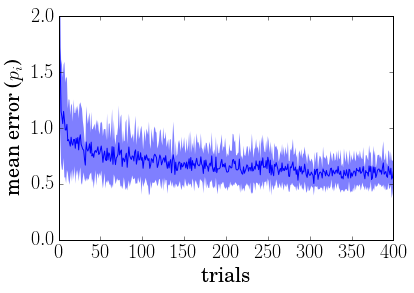

In [4]:
plt.close()
plt.axes(xlim=[0,400],ylim=[0,2])
VectorFigUtils.drawPlotXY(range(len(mean_error_s)),mean_error_s,mean_var_s,xlabel="trials",ylabel="mean error ($p_i$)")
plt.show()
#fig.savefig('imgs/RandomBablingError.png', dpi=300, format='png')

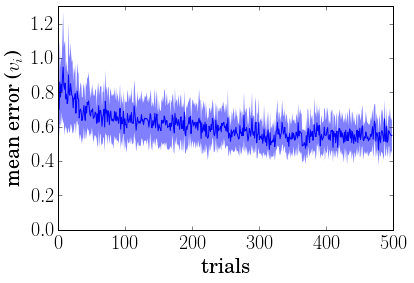

In [5]:
plt.close()
plt.axes(xlim=[0,500],ylim=[0,1.3])
VectorFigUtils.drawPlotXY(range(len(mean_error_ds)),mean_error_ds,mean_var_ds,xlabel="trials",ylabel="mean error ($v_i$)")
plt.show()

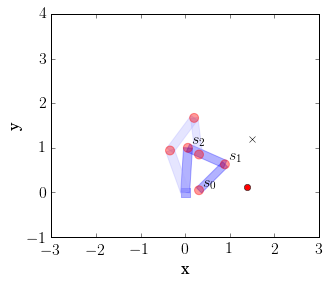

In [50]:
fig, ax = Box2DWorld.makeFigure(axes=[-3,3,-1,4])
# individual test of a forward prediction
mdm = env.random_motors(n=1)[0]
m,dm = mdm[:3], mdm[3:]    
s = np.array(arm.gotoTargetJoints(m))
Box2DWorld.plotAll(ax,centers=arm.getSalient(),label="s",xlabel="x",ylabel="y",mainfont=16)
s_after = np.array(arm.deltaMotorUpdate(dm))
Box2DWorld.plotAll(ax,color='#aaaaff',centers=arm.getSalient(),xlabel="x",ylabel="y",mainfont=16)

ds = s_after-s
sds = np.hstack((s, ds))
sds_pred = fmdmsds.forward_prediction(mdm)
s_pred = sds_pred[:2]
ds_pred = sds_pred[2:]

ax.plot(*s_pred, marker='o', color='red')
ax.plot(*list(np.array(s_pred)+np.array(ds_pred)), marker='x', color='k')
#ax.plot(*list(np.array(s_context)+np.array(ds_context)), marker='x', color='r')
#ax.plot(*list(np.array(s_fwd)+np.array(ds_fwd)), marker='x', color='b')

plt.show()

In [4]:
fmdmsds.mode = "exploit"
fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])

mdm = env.getRandomInput()
m,dm = mdm[:3], mdm[3:]
s = arm.gotoTargetJoints(m)
Box2DWorld.plotWorld(ax)
Box2DWorld.plotVectors(ax, arm.getSalient())

# prediction with context
c,c_dims = s, [0,1]   # context x,y pos
sds = fmdmsds.predict_given_context(mdm, c, c_dims)
s_context = sds[:2]
ds_context = sds[2:]

# infer fixing some dimentions
in_dims = env.conf.m_dims + env.conf.s_dims[:2]
out_dims = env.conf.s_dims[2:]
ds_infer = fmdmsds.infer(in_dims, out_dims, mdm+s)

sds_pred = fmdmsds.forward_prediction(mdm)
s_fwd,ds_fwd = sds_pred[:2],sds_pred[2:]

s2 = arm.deltaMotorUpdate(dm)

Box2DWorld.plotAll(ax,color='#aaaaff',centers=arm.getSalient(),xlabel="x",ylabel="y",title="Arm Simulation",mainfont=16)

ax.plot(*s, marker='o', color='red')
ax.plot(*list(np.array(s)+np.array(ds_infer)), marker='x', color='k')
ax.plot(*list(np.array(s_context)+np.array(ds_context)), marker='x', color='r')
ax.plot(*list(np.array(s_fwd)+np.array(ds_fwd)), marker='x', color='b')
plt.grid()
plt.show()

NotImplementedError: 

#### sampling the interest model with context

In [3]:
c = [1, 2]    # context
c_dims = [0, 1] # end position's dimensions
ds = fmdmsds_im.sample_given_context(c, c_dims)
print "Sampling interesting goal with end pos context =", c, ": ds=", ds

Sampling interesting goal with end pos context = [1, 2] : ds= [ 1.35681414  0.27816949]


###  $f(M, \Delta M) = \langle S, \Delta S \rangle$ learning from scratch with progress goal babbling


In [3]:
fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])
error,mean_error,mean_var = [],[],[]
c_dims = [0, 1] 
for i in range(3000):
    c = arm.getFinalPos()
    ds_g = fmdmsds_im.sample_given_context(c,c_dims)
    if(fmdmsds.size()>2): mdm = fmdmsds.inverse_prediction(np.hstack((c, ds_g)))           
    else: mdm = env.getRandomInput()
    
    s = arm.gotoTargetJoints(mdm[:3])
    snew = arm.deltaMotorUpdate(mdm[3:])
    ds = np.array(snew) - np.array(s) 
    sds = np.hstack((np.array(s),ds))
    
    fmdmsds.update(mdm, sds)                                        # update the sensorimotor model
    if(fmdmsds.size()>2): 
        VectorFigUtils.error_monitor(ds,ds_g,error,mean_error,mean_var)            
        fmdmsds_im.update(np.hstack((mdm, s, ds_g)), np.hstack((mdm, sds)))   # update the interest model

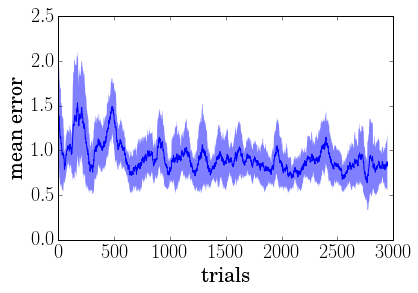

In [4]:
plt.close()
VectorFigUtils.drawPlotXY(range(len(mean_error)),mean_error,mean_var,xlabel="trials",ylabel="mean error")
plt.show()
fig.savefig('imgs/InterestBabblingError.png', dpi=300, format='png')